In [16]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
train_data = pd.read_csv('/content/drive/My Drive/Re_SA/MLs/train_df_balanced.csv');
train_data

,text,label
0,"Game felt too restrictive for my taste, also c...",0
1,This is hands down the worst tutorial I have e...,0
2,I know this might sound dumb to 99% of the pla...,0
3,"I turned off the online function and STILL, OT...",0
4,"as does the Quest 2 headset itself, as well a...",0
...,...,...
1195,love taking photo another planet,2
1196,I used to keep a notepad on my phone that I up...,2
1197,goofy diseases and even more goofy ways to cur...,2
1198,the game features a range of fun and challengi...,2


In [19]:
test_data = pd.read_csv('/content/drive/My Drive/Re_SA/MLs/test_df_imbalanced.csv');
test_data

,text,label
0,which is pretty intuitive and easy to learn.,2
1,"weapon handling, hit reaction and the ""punchy ...",2
2,Crash on startup every time,0
3,scratches and itch but falls short of providin...,0
4,There's sort of the illusion of split paths a...,0
...,...,...
1967,"It's quite fast paced,",1
1968,I have some mixed feelings after the free week...,1
1969,a sad E-sport failure.,0
1970,Hold to confirm There actually is an option ...,0


# Naive Bayes

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best parameters found:  {'classifier__alpha': 0.5, 'vectorizer__max_features': 1000, 'vectorizer__ngram_range': (1, 2)}
Cross-validation scores:  [0.52916667 0.4875     0.47916667 0.54583333 0.54166667]
Mean cross-validation score:  0.5166666666666666
              precision    recall  f1-score   support

           0      0.665     0.641     0.653       701
           1      0.378     0.755     0.504       274
           2      0.793     0.596     0.680       997

    accuracy                          0.634      1972
   macro avg      0.612     0.664     0.612      1972
weighted avg      0.690     0.634     0.646      1972

Predictions saved to /content/drive/My Drive/Re_SA/MLs/NB_Bow_predictions.csv


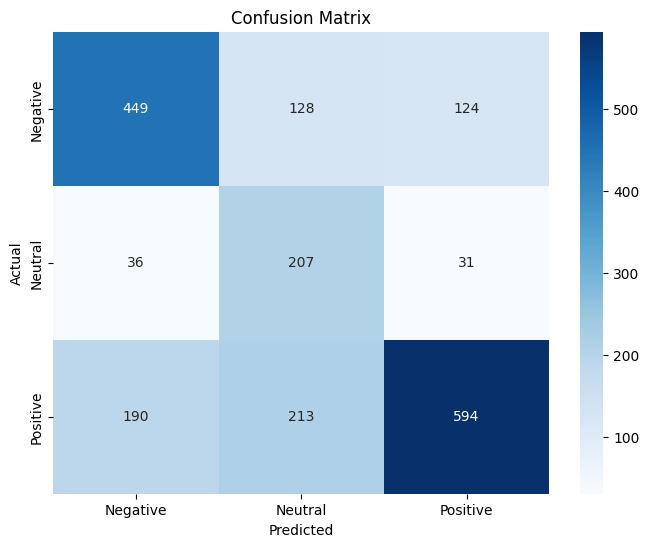

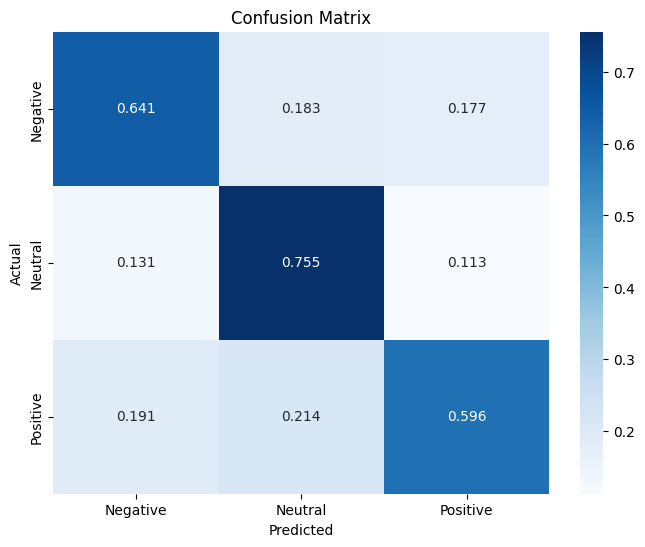

In [22]:
def load_data(train_filepath, test_filepath):
    train_data = pd.read_csv(train_filepath)
    test_data = pd.read_csv(test_filepath)
    return train_data['text'], train_data['label'], test_data['text'], test_data['label']

# Preprocess text
def preprocess_text(text, min_length):
    return ' '.join([word for word in text.split() if len(word) >= min_length])

# Main function
def main():
    # Load and preprocess data
    train_filepath = '/content/drive/My Drive/Re_SA/MLs/train_df_balanced.csv'
    test_filepath = '/content/drive/My Drive/Re_SA/MLs/test_df_imbalanced.csv'
    X_train, y_train, X_test, y_test = load_data(train_filepath, test_filepath)
    X_train = X_train.apply(preprocess_text, min_length=0)  # Minimum word length filter
    X_test = X_test.apply(preprocess_text, min_length=0)

    # Define the pipeline
    pipeline = Pipeline([
        ('vectorizer', CountVectorizer()),  # Vectorizer placeholder
        ('classifier', MultinomialNB())  # Naive Bayes classifier
    ])

    # Define parameter grid for GridSearchCV
    param_grid = {
        'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
        'vectorizer__max_features': [1000, 5000, 10000],
        'classifier__alpha': [0.1, 0.5, 1.0, 1.5, 2.0]  # Laplace smoothing parameter
    }

    # Initialize GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)

    # Fit the model with cross-validation
    grid_search.fit(X_train, y_train)

    # Best parameters
    print("Best parameters found: ", grid_search.best_params_)

    # Perform cross-validation on the best estimator
    cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5)
    print("Cross-validation scores: ", cv_scores)
    print("Mean cross-validation score: ", cv_scores.mean())

    # Predict and evaluate on the test set
    y_pred = grid_search.predict(X_test)
    print(classification_report(y_test, y_pred, digits=3))


   # Save the predictions to a CSV file
    output_filepath = '/content/drive/My Drive/Re_SA/MLs/NB_Bow_predictions.csv'  # Define your output path
    pd.DataFrame({'Text':X_test,'Actual': y_test, 'Predicted': y_pred}).to_csv(output_filepath, index=False)
    print(f"Predictions saved to {output_filepath}")


    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, normalize="true")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


if __name__ == "__main__":
    main()


# Decision Tree

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best parameters found:  {'classifier__criterion': 'gini', 'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'vectorizer__max_features': 10000, 'vectorizer__ngram_range': (1, 2)}
Cross-validation scores:  [0.40833333 0.45833333 0.4125     0.425      0.425     ]
Mean cross-validation score:  0.4258333333333334
              precision    recall  f1-score   support

           0      0.703     0.395     0.506       701
           1      0.221     0.909     0.355       274
           2      0.697     0.314     0.433       997

    accuracy                          0.425      1972
   macro avg      0.540     0.539     0.431      1972
weighted avg      0.633     0.425     0.448      1972

Predictions saved to /content/drive/My Drive/Re_SA/MLs/DT_Bow_predictions.csv


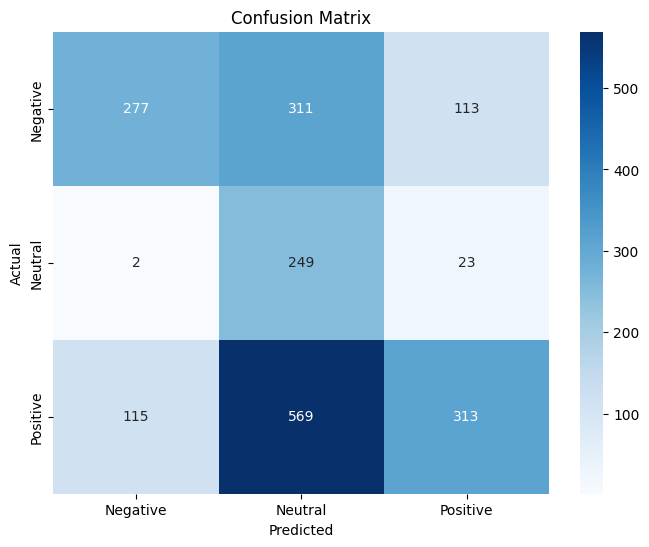

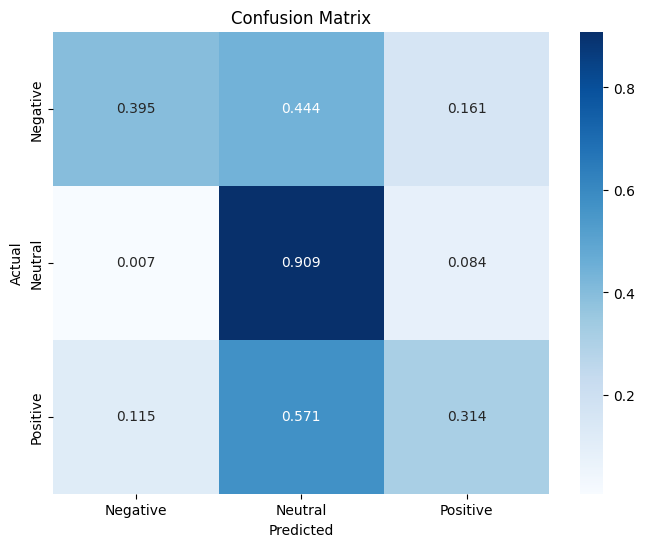

In [23]:
def load_data(train_filepath, test_filepath):
    train_data = pd.read_csv(train_filepath)
    test_data = pd.read_csv(test_filepath)
    return train_data['text'], train_data['label'], test_data['text'], test_data['label']

# Preprocess text
def preprocess_text(text, min_length):
    return ' '.join([word for word in text.split() if len(word) >= min_length])

# Main function
def main():
    # Load and preprocess data
    train_filepath = '/content/drive/My Drive/Re_SA/MLs/train_df_balanced.csv'
    test_filepath = '/content/drive/My Drive/Re_SA/MLs/test_df_imbalanced.csv'
    X_train, y_train, X_test, y_test = load_data(train_filepath, test_filepath)
    X_train = X_train.apply(preprocess_text, min_length=0)  # Minimum word length filter
    X_test = X_test.apply(preprocess_text, min_length=0)


    # Define the pipeline
    pipeline = Pipeline([
        ('vectorizer', CountVectorizer()),  # Vectorizer placeholder
        ('classifier', DecisionTreeClassifier())  # Decision Tree classifier
    ])

    # Define parameter grid for GridSearchCV
    param_grid = {
        'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
        'vectorizer__max_features': [1000, 5000, 10000],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    }

    # Initialize GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)

    # Fit the model with cross-validation
    grid_search.fit(X_train, y_train)

    # Best parameters
    print("Best parameters found: ", grid_search.best_params_)

    # Perform cross-validation on the best estimator
    cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5)
    print("Cross-validation scores: ", cv_scores)
    print("Mean cross-validation score: ", cv_scores.mean())

    # Predict and evaluate on the test set
    y_pred = grid_search.predict(X_test)
    print(classification_report(y_test, y_pred, digits=3))


   # Save the predictions to a CSV file
    output_filepath = '/content/drive/My Drive/Re_SA/MLs/DT_Bow_predictions.csv'  # Define your output path
    pd.DataFrame({'Text':X_test,'Actual': y_test, 'Predicted': y_pred}).to_csv(output_filepath, index=False)
    print(f"Predictions saved to {output_filepath}")



    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, normalize="true")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


if __name__ == "__main__":
    main()

# Linear SVM

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters found:  {'classifier__C': 1, 'feature_selection__k': 'all', 'feature_selection__score_func': <function chi2 at 0x7c5d40374c10>, 'vectorizer__max_features': 10000, 'vectorizer__ngram_range': (1, 2)}
Cross-validation scores:  [0.525      0.5125     0.46666667 0.525      0.55416667]
Mean cross-validation score:  0.5166666666666667
              precision    recall  f1-score   support

           0      0.783     0.648     0.709       701
           1      0.435     0.993     0.605       274
           2      0.868     0.668     0.755       997

    accuracy                          0.706      1972
   macro avg      0.695     0.769     0.690      1972
weighted avg      0.778     0.706     0.718      1972

Predictions saved to /content/drive/My Drive/Re_SA/MLs/LSVM_Bow_predictions.csv


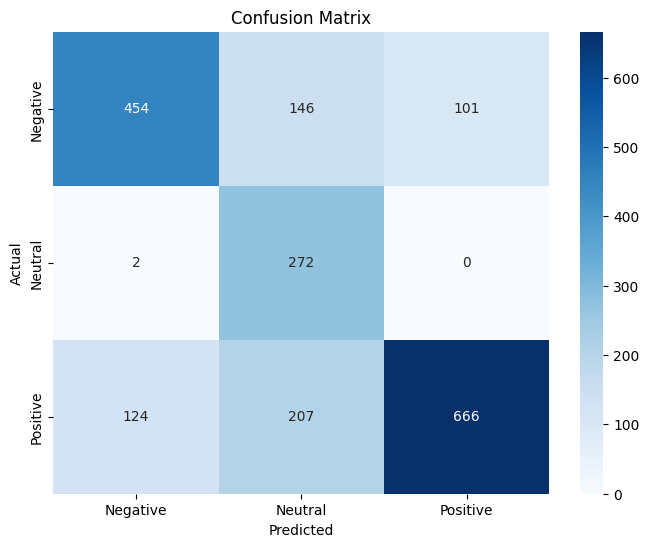

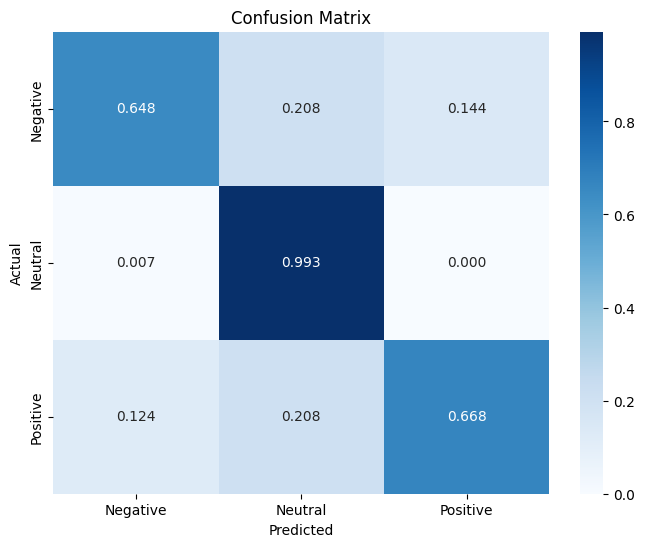

In [24]:
def load_data(train_filepath, test_filepath):
    train_data = pd.read_csv(train_filepath)
    test_data = pd.read_csv(test_filepath)
    return train_data['text'], train_data['label'], test_data['text'], test_data['label']

# Preprocess text
def preprocess_text(text, min_length):
    return ' '.join([word for word in text.split() if len(word) >= min_length])

# Main function
def main():
    # Load and preprocess data
    train_filepath = '/content/drive/My Drive/Re_SA/MLs/train_df_balanced.csv'
    test_filepath = '/content/drive/My Drive/Re_SA/MLs/test_df_imbalanced.csv'
    X_train, y_train, X_test, y_test = load_data(train_filepath, test_filepath)
    X_train = X_train.apply(preprocess_text, min_length=0)  # Example of minimum word length filter
    X_test = X_test.apply(preprocess_text, min_length=0)


    # Define the pipeline
    pipeline = Pipeline([
        ('vectorizer', CountVectorizer()),  # Vectorizer placeholder
        ('feature_selection', SelectKBest()),  # Feature selection placeholder
        ('classifier', LinearSVC())  # Use LinearSVC classifier
    ])

    # Define parameter grid for GridSearchCV
    param_grid = {
        'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
        'vectorizer__max_features': [1000, 5000, 10000],
        'feature_selection__score_func': [chi2],
        'feature_selection__k': [500, 1000, 'all'],
        'classifier__C': [0.1, 1, 10]  # Removed 'kernel' since LinearSVC only has a linear kernel
    }

    # Initialize GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)

    # Fit the model with cross-validation
    grid_search.fit(X_train, y_train)

    # Best parameters
    print("Best parameters found: ", grid_search.best_params_)

    # Perform cross-validation on the best estimator
    cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5)
    print("Cross-validation scores: ", cv_scores)
    print("Mean cross-validation score: ", cv_scores.mean())

    # Predict and evaluate on the test set
    y_pred = grid_search.predict(X_test)
    print(classification_report(y_test, y_pred, digits=3))



   # Save the predictions to a CSV file
    output_filepath = '/content/drive/My Drive/Re_SA/MLs/LSVM_Bow_predictions.csv'  # Define your output path
    pd.DataFrame({'Text':X_test,'Actual': y_test, 'Predicted': y_pred}).to_csv(output_filepath, index=False)
    print(f"Predictions saved to {output_filepath}")



    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()



    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, normalize="true")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


if __name__ == "__main__":
    main()



# Non-linear SVM

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
405 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
405 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/

Best parameters found:  {'classifier__C': 10, 'classifier__kernel': 'rbf', 'feature_selection__k': 1000, 'feature_selection__score_func': <function chi2 at 0x7c5d40374c10>, 'vectorizer__max_features': 5000, 'vectorizer__ngram_range': (1, 1)}
Cross-validation scores:  [0.50833333 0.51666667 0.48333333 0.54166667 0.49583333]
Mean cross-validation score:  0.5091666666666667
              precision    recall  f1-score   support

           0      0.748     0.705     0.726       701
           1      0.452     0.978     0.618       274
           2      0.876     0.632     0.734       997

    accuracy                          0.706      1972
   macro avg      0.692     0.772     0.693      1972
weighted avg      0.772     0.706     0.715      1972

Predictions saved to /content/drive/My Drive/Re_SA/MLs/NLSVM_Bow_predictions.csv


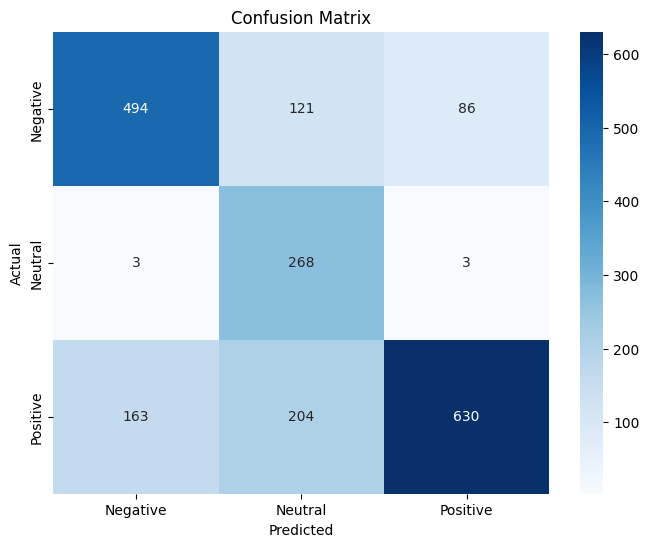

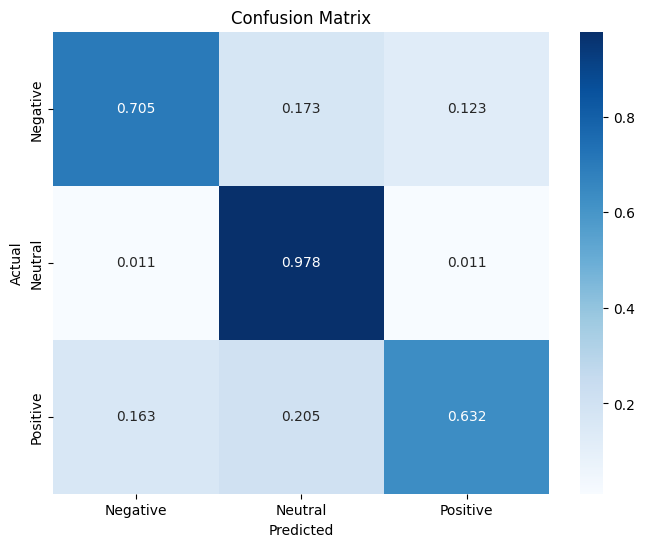

In [25]:
def load_data(train_filepath, test_filepath):
    train_data = pd.read_csv(train_filepath)
    test_data = pd.read_csv(test_filepath)
    return train_data['text'], train_data['label'], test_data['text'], test_data['label']

# Preprocess text
def preprocess_text(text, min_length):
    return ' '.join([word for word in text.split() if len(word) >= min_length])

# Main function
def main():
    # Load and preprocess data
    train_filepath = '/content/drive/My Drive/Re_SA/MLs/train_df_balanced.csv'
    test_filepath = '/content/drive/My Drive/Re_SA/MLs/test_df_imbalanced.csv'
    X_train, y_train, X_test, y_test = load_data(train_filepath, test_filepath)
    X_train = X_train.apply(preprocess_text, min_length=0)  # Example of minimum word length filter
    X_test = X_test.apply(preprocess_text, min_length=0)


   # Define the pipeline
    pipeline = Pipeline([
        ('vectorizer', CountVectorizer()),  # Vectorizer placeholder
        ('feature_selection', SelectKBest()),  # Feature selection placeholder
        ('classifier', SVC())  # SVM classifier
    ])

    # Define parameter grid for GridSearchCV
    param_grid = {
        'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
        'vectorizer__max_features': [1000, 5000, 10000],
        'feature_selection__score_func': [chi2],
        'feature_selection__k': [500, 1000, 'all'],
        'classifier__kernel': ['poly', 'rbf','sigmoid','precomputed'],
        'classifier__C': [0.1, 1, 10]
    }

    # Initialize GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)

    # Fit the model with cross-validation
    grid_search.fit(X_train, y_train)

    # Best parameters
    print("Best parameters found: ", grid_search.best_params_)

    # Perform cross-validation on the best estimator
    cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5)
    print("Cross-validation scores: ", cv_scores)
    print("Mean cross-validation score: ", cv_scores.mean())

    # Predict and evaluate on the test set
    y_pred = grid_search.predict(X_test)
    print(classification_report(y_test, y_pred, digits=3))




   # Save the predictions to a CSV file
    output_filepath = '/content/drive/My Drive/Re_SA/MLs/NLSVM_Bow_predictions.csv'  # Define your output path
    pd.DataFrame({'Text':X_test,'Actual': y_test, 'Predicted': y_pred}).to_csv(output_filepath, index=False)
    print(f"Predictions saved to {output_filepath}")



    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()



    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, normalize="true")
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.3f', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


if __name__ == "__main__":
    main()

In [15]:
%%shell
jupyter nbconvert --to html /content/all_tfidf.ipynb

[NbConvertApp] Converting notebook /content/all_tfidf.ipynb to html
[NbConvertApp] Writing 956811 bytes to /content/all_tfidf.html
